**Amaç;VeriSeti;Yöntem;**

Bu çalışmamda UTKFace verisetine dayanarak resimleri yüklenen insanların yaşlarını tahmin etmek için oluşturdum.

## Kütüpanelerin import edilmesi

In [1]:
import numpy as np # matris işlemleri
import pandas as pd # tablo işlemleri
import matplotlib.pyplot as plt # görselleştirme
import tensorflow as tf # model kurma
import os
import cv2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import glob


## Veri seti

In [2]:
main_path = "../input/utkface-new/UTKFace/" # görüntülerin bulunduğu dizin

In [3]:
df = {"img_path":[],"age":[]} # bilgilerin tutulacağı dataframe

In [4]:
for path in os.listdir(main_path):
    age = int(path.split("_")[0])
    df["age"].append(age)
    df["img_path"].append(main_path+path)
    
df = pd.DataFrame(df)
df

,img_path,age
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17
...,...,...
23703,../input/utkface-new/UTKFace/41_0_0_2017010901...,41
23704,../input/utkface-new/UTKFace/42_0_0_2017011718...,42
23705,../input/utkface-new/UTKFace/2_0_2_20161219221...,2
23706,../input/utkface-new/UTKFace/65_1_0_2017011018...,65


## Görselleştirme

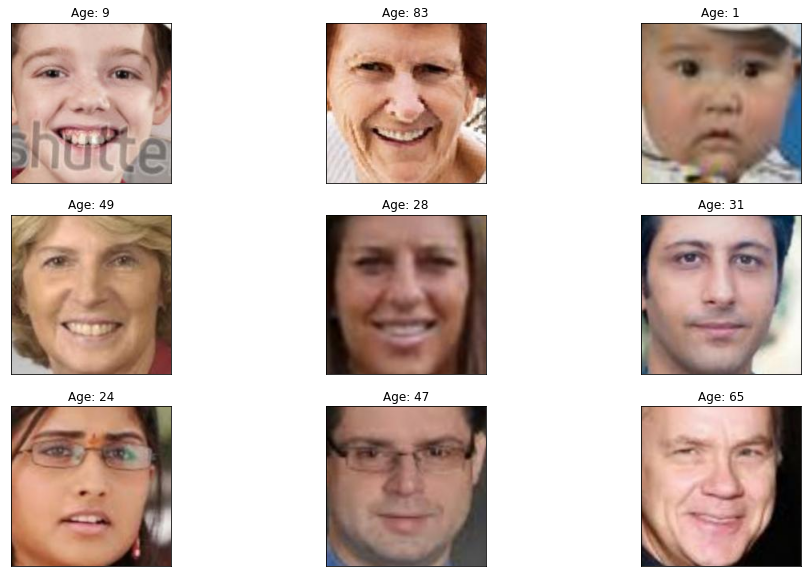

In [5]:
plt.figure(figsize=(16,10))
for i in range(9):
    rnd = np.random.randint(len(df["img_path"]))
    img_path = df["img_path"][rnd]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,3,i+1)
    plt.title("Age: "+str(df["age"][rnd]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
plt.show()

## Model kurma

In [6]:
img_width,img_height,img_channel = (100,100,1) # resim boyutları 
input_shape = (img_width,img_height,img_channel)  # model  girdisi

In [7]:
inputs = Input((input_shape))
# Konvolüstonel katmanlar
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4) # piksellerin düzleştirilmesi

# fully connected katmanlar
dense_out= Dense(32, activation='relu') (flatten)

dropout = Dropout(0.3) (dense_out)

output = Dense(1, activation='relu', name='age_out') (dropout)

model = Model(inputs=[inputs], outputs=output)

model.compile(loss=[ 'mae'], optimizer='adam', metrics=['accuracy'])

2022-05-19 18:53:28.662150: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 18:53:28.671802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 18:53:28.672527: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 18:53:28.673683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0     

## Verilerin hazırlanması

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state = 1)

In [11]:
df_train.shape, df_test.shape

((21337, 2), (2371, 2))

In [12]:
df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state = 1)

In [13]:
df_train.shape, df_valid.shape

((19203, 2), (2134, 2))

In [14]:
from tensorflow.keras.utils import Sequence
class DataGen(Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=5):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            ## Read image and mask
            image = cv2.imread(images_path[i],cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(img_height,img_width))
            mask = masks_path[i]
            
            images_batch.append(image)
            mask = np.array(mask,dtype = "float")
            
            masks_batch.append(mask)

        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))

In [15]:
batch_size = 32
train_gen = DataGen(100, df_train.loc[:,"img_path"].values, df_train.loc[:,"age"].values, batch_size=batch_size)
valid_gen = DataGen(100, df_valid.loc[:,"img_path"].values, df_valid.loc[:,"age"].values, batch_size=batch_size)

## Model eğitimi

In [16]:
model.compile(optimizer="adam",
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0     

In [18]:
train_steps = len(df_train.loc[:,"img_path"].values)//batch_size
valid_steps = len(df_valid.loc[:,"img_path"].values)//batch_size

In [19]:
train_steps, valid_steps

(600, 66)

In [20]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("classify_model.h5", verbose=1, save_best_only=True,mode = "max", monitor = "val_accuracy")

In [21]:
model.fit(train_gen,
            validation_data=valid_gen,
            steps_per_epoch=train_steps,
            validation_steps=valid_steps,
            epochs=70,
            callbacks=[checkpoint])

2022-05-19 18:53:30.354006: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-05-19 18:53:31.278251: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


600/600 [==============================] - 21s 32ms/step - loss: 508.9361 - accuracy: 0.0441 - val_loss: 584.6580 - val_accuracy: 0.0473

Epoch 00001: val_accuracy improved from -inf to 0.04735, saving model to classify_model.h5
Epoch 2/70
600/600 [==============================] - 5s 9ms/step - loss: 471.2305 - accuracy: 0.0500 - val_loss: 293.4454 - val_accuracy: 0.0510

Epoch 00002: val_accuracy improved from 0.04735 to 0.05096, saving model to classify_model.h5
Epoch 3/70
600/600 [==============================] - 5s 8ms/step - loss: 417.5512 - accuracy: 0.0483 - val_loss: 330.8013 - val_accuracy: 0.0530

Epoch 00003: val_accuracy improved from 0.05096 to 0.05303, saving model to classify_model.h5
Epoch 4/70
600/600 [==============================] - 5s 8ms/step - loss: 381.5114 - accuracy: 0.0528 - val_loss: 272.9261 - val_accuracy: 0.0530

Epoch 00004: val_accuracy did not improve from 0.05303
Epoch 5/70
600/600 [==============================] - 5s 8ms/step - loss: 416.6314 - ac

## Sonuçları görselleştirme

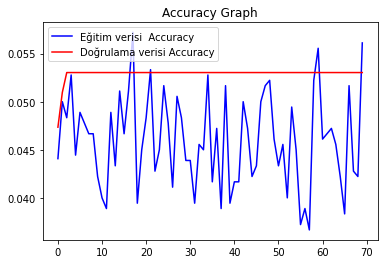

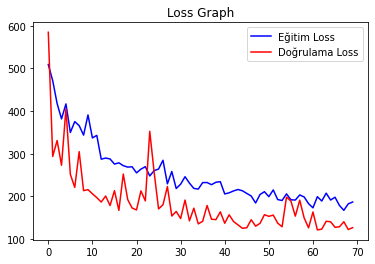

In [22]:
# plot results for gender
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Eğitim verisi  Accuracy')
plt.plot(epochs, val_acc, 'r', label='Doğrulama verisi Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Eğitim Loss')
plt.plot(epochs, val_loss, 'r', label='Doğrulama Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [23]:
test_gen = DataGen(100, df_test.loc[:,"img_path"].values, df_test.loc[:,"age"].values, batch_size=batch_size)

In [24]:
preds = model.predict_generator(test_gen,verbose=1).ravel()

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


75/75 [==============================] - 15s 195ms/step


In [25]:
from sklearn.metrics import mean_squared_error

# test result

In [26]:
mean_squared_error(test_gen.masks_path, preds)

129.23675429798703

In [27]:
df_test = df_test.reset_index(drop=True)

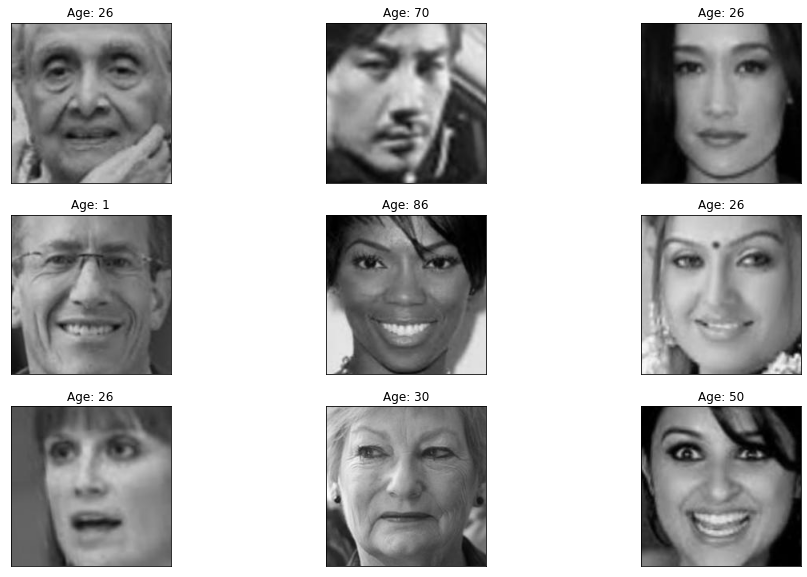

In [28]:
plt.figure(figsize=(16,10))
for i in range(9):
    rnd = np.random.randint(len(df_test["img_path"]))
    img_path = df_test["img_path"][rnd]
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_gray =  cv2.resize(img_gray, (100,100))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gercek_yas = "Gerçek yaş: " +str(df["age"][rnd])
    tahmin_yas = "-- Tahmin: " + str(model.predict(img_gray.reshape(1,100,100,1))[0])
    title = gercek_yas + tahmin_yas
    plt.subplot(3,3,i+1)
    plt.title("Age: "+str(df["age"][rnd]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    
plt.show()
